In [510]:
import numpy as np
from numpy import exp, tanh, sqrt, dot
from numpy.linalg import inv, eig, solve
import matplotlib.pyplot as plt
from scipy.special import riccati_jn, riccati_yn,spherical_jn, spherical_yn
%matplotlib inline
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rcParams.update({'font.size': 18})

# Log-Derivative for Atom-Ion Collision

In [458]:
def Vmat(r):
    ''' Construct the matrix of potentials for He+ + Ne including all
    channels and their couplings'''
    a1 = 21.1
    a2 = 0.678
    a3 = 12.1
    a4 = 0.170
    a5 = 0.667
    V1 = a1/r*exp(-r/a2)
    V2 = (a1/r-a3)*exp(-r/a2) + 0.6173887
    V12 = a4*exp(-r/a5)
    return np.array([[V1, V12],
                    [V12, V2]])

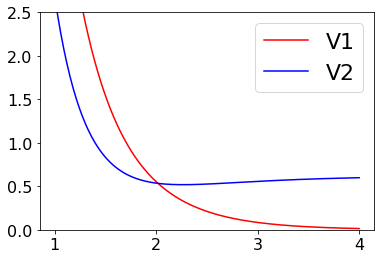

In [452]:
# Plot the potentials to make sure they look right
r = np.linspace(1,4,200)
v1 = []
v2 = []
for rr in r:
    v1.append(Vmat(rr)[0,0])
    v2.append(Vmat(rr)[1,1])
plt.plot(r,v1,'r',label="V1")
plt.plot(r,v2,'b',label="V2")
plt.ylim(0,2.5)
plt.legend()

In [459]:
# Solve the log-derivative method for this interaction potential
def logderiv(npts,Rmin,Rmax,E0,l):
    # numerically integrate equation dy/dR  + W(R) + y^2 = 0
    # on grid of points from Rmin to Rmax and npts points
    
    # mass in atomic units
    m = 6089.0
    # convert energy to atomic units
    E = E0/Eh
    
    # identity matrix and other initializations
    dims = Vmat(Rmax).shape[0]
    idn = np.eye(dims)
    Jmat = np.zeros((dims,dims))
    Jpmat = np.zeros((dims,dims))
    Nmat = np.zeros((dims,dims))
    Npmat = np.zeros((dims,dims))
    
    # k-vector from energy
    kn = np.zeros((dims))
    kn[0] = sqrt(2*m*(E-Vmat(10*Rmax)[0,0]))
    kn[1] = sqrt(2*m*(E-Vmat(10*Rmax)[1,1]))
    
    # step size
    h = (Rmax - Rmin)/(npts)

    # initialize solution
    y = np.zeros((2,2,npts+1))
    y[:,:,0] = 1e20 * idn

    # W(r) appearing in differential equation
    E0mat = np.diag(kn**2)
    def W(x):
        return E0mat - idn*l*(l+1)/x**2 - 2*m*Vmat(x)
    
    # integrate outward from classically forbidden region
    R = Rmin
    for n in range(1,npts+1):
        # step to next radius
        R += h
        # function values for integration on grid
        Wn = W(R)
        if n%2 == 0:
            u = Wn
        else:
            u = np.linalg.solve(idn+(h**2)/6*Wn, Wn)

        # weights from Simpson integration rule
        if (n == 0)or(n==npts):
            w = 1
        elif n%2 == 0:
            w = 2
        else:
            w = 4
        # numerical integration formula for log-derivative solution
        y[:,:,n] = np.linalg.solve(idn+h*y[:,:,n-1],y[:,:,n-1]) - (h/3)*w*u
    yend = y[:,:,-1]

    # make K-matrix
    for ii in range(dims):
        jl = spherical_jn(l,R*kn[ii])
        jlp = spherical_jn(l,R*kn[ii],derivative=True)
        yl = spherical_yn(l,R*kn[ii])
        ylp = spherical_yn(l,R*kn[ii],derivative=True)
        Jmat[ii,ii] = sqrt(kn[ii])*R*jl
        Jpmat[ii,ii] = sqrt(kn[ii])*(kn[ii]*R*jlp + jl)
        Nmat[ii,ii] = sqrt(kn[ii])*R*yl
        Npmat[ii,ii] = sqrt(kn[ii])*(kn[ii]*R*ylp + yl)
    Kmat = np.linalg.solve(yend.dot(Nmat) - Npmat, yend.dot(Jmat) - Jpmat)
    
    # make S-matrix
    Smat = (idn+1j*Kmat).dot(inv(idn-1j*Kmat))

    return y, Kmat, Smat

In [462]:
outlist = []
for ll in range(250):
    y,K,S=logderiv(6000,0,6,2.60566*Eh,ll)
    outlist.append(abs(S[0,1])**2)

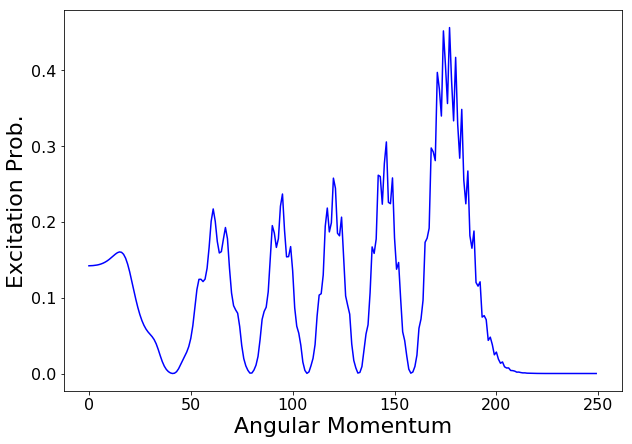

In [465]:
f=plt.figure(figsize=(10,7))
plt.plot(outlist,'b-')
plt.ylabel('Excitation Prob.')
plt.xlabel('Angular Momentum')
#f.savefig("AtomIonCol.pdf",bbox_inches='tight')

# Log-Derivative Method for Atom-Molecule Collision

In [869]:
3/Eh

1.366900771205415e-05

In [870]:
## Model potentials for He + alkaline-earth atom collisions
# Hartrees from cm^-1
Eh = 219474.6

# define the V matrix
lam1 = [0.813, 0.677]
lam2 = [1.2014, 2.2061]
lam3 = [5.5701, 6.2093]
C1 = [0.017, -0.0354]
C2 = [3.065, -336.426]
C3 = [-0.5819, 146.481]
C4 = [15.82, 13.5519]
A = 3.0 / Eh

def Vch(r):
    ''' Function to evaluate the potential for each channel
    involved in the scattering problem. '''
    Vsig = C1[0]*exp(-lam1[0]*r) + (C2[0]+C3[0]*r)*exp(-lam2[0]*r) - C4[0]/2*(tanh(1.2*(r-lam3[0]))+1)/r**6
    Vpi = C1[1]*exp(-lam1[1]*r) + (C2[1]+C3[1]*r)*exp(-lam2[1]*r) - C4[1]/2*(tanh(1.2*(r-lam3[1]))+1)/r**6
    return np.array([Vsig,Vpi])

def Vmat(r):
    ''' Construct the matrix of for Cl + H2 potentials including all
    channels and their couplings'''
    vsig, vpi = Vch(r)
    return np.array([[2/3*vsig+1/3*vpi-A, sqrt(2)/3*(vpi-vsig)],
                    [sqrt(2)/3*(vpi-vsig), 1/3*vsig+2/3*vpi+2*A]])


In [871]:
# Solve the log-derivative method for this interaction potential
def logderiv(npts,Rmin,Rmax,E0,l):
    # numerically integrate equation dy/dR  + W(R) + y^2 = 0
    # on grid of points from Rmin to Rmax and npts points
    
    # mass in atomic units
    m = 5193.0
    # convert energy to atomic units
    E = E0/Eh
    
    # identity matrix and other initializations
    dims = Vmat(Rmax).shape[0]
    idn = np.eye(dims)
    Jmat = np.zeros((dims,dims))
    Jpmat = np.zeros((dims,dims))
    Nmat = np.zeros((dims,dims))
    Npmat = np.zeros((dims,dims))
    
    # k-vector from energy
    kn = np.zeros((dims))
    kn[0] = sqrt(2*m*(E-Vmat(10*Rmax)[0,0]))
    kn[1] = sqrt(2*m*(E-Vmat(10*Rmax)[1,1]))
    
    # step size
    h = (Rmax - Rmin)/(npts)

    # initialize solution
    y = np.zeros((2,2,npts+1))
    y[:,:,0] = 1e20 * idn

    # W(r) appearing in differential equation
    E0mat = np.diag(kn**2)
    def W(x):
        return E0mat - idn*l*(l+1)/x**2 - 2*m*Vmat(x)
    
    # integrate outward from classically forbidden region
    R = Rmin
    for n in range(1,npts+1):
        # step to next radius
        R += h
        # function values for integration on grid
        Wn = W(R)
        if n%2 == 0:
            u = Wn
        else:
            u = np.linalg.solve(idn+(h**2)/6*Wn, Wn)

        # weights from Simpson integration rule
        if (n == 0)or(n==npts):
            w = 1
        elif n%2 == 0:
            w = 2
        else:
            w = 4
        # numerical integration formula for log-derivative solution
        y[:,:,n] = np.linalg.solve(idn+h*y[:,:,n-1],y[:,:,n-1]) - (h/3)*w*u
    yend = y[:,:,-1]

    # make K-matrix
    for ii in range(dims):
        jl = spherical_jn(l,R*kn[ii])
        jlp = spherical_jn(l,R*kn[ii],derivative=True)
        yl = spherical_yn(l,R*kn[ii])
        ylp = spherical_yn(l,R*kn[ii],derivative=True)
        Jmat[ii,ii] = sqrt(kn[ii])*R*jl
        Jpmat[ii,ii] = sqrt(kn[ii])*(kn[ii]*R*jlp + jl)
        Nmat[ii,ii] = sqrt(kn[ii])*R*yl
        Npmat[ii,ii] = sqrt(kn[ii])*(kn[ii]*R*ylp + yl)
    Kmat = np.linalg.solve(yend.dot(Nmat) - Npmat, yend.dot(Jmat) - Jpmat)
    
    # make S-matrix
    Smat = (idn+1j*Kmat).dot(inv(idn-1j*Kmat))

    return y, Kmat, Smat

Make sure we converge to a stable S-matrix for some example parameters.

In [872]:
outlist = []
nlist = range(50,4000,10)
for nn in nlist:
    y,K,S = logderiv(nn,0.005,22,1000,0)
    outlist.append(abs(S[0,1])**2)

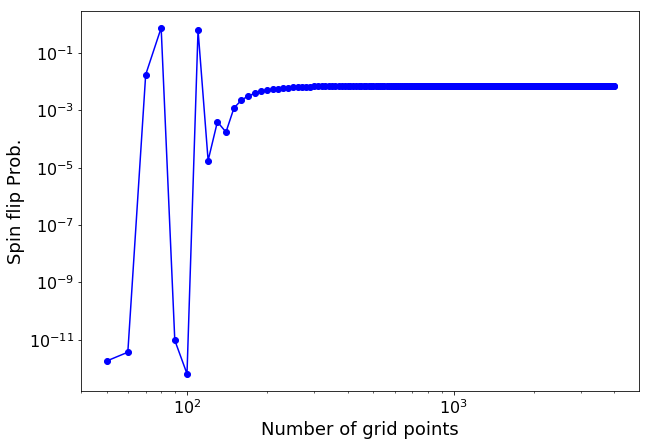

In [873]:
f = plt.figure(figsize=(10,7))
plt.loglog(nlist,outlist,'bo-')
plt.xlabel('Number of grid points')
plt.ylabel('Spin flip Prob.')
#f.savefig("Convergence.pdf", bbox_inches='tight')

Examine S-matrix vs. energy.

In [857]:
outlist50 = []
Elist = range(20,1800,10)
for EE in Elist:
    y,K,S = logderiv(400,0.005,22,EE,50)
    outlist50.append(abs(S[0,1])**2)

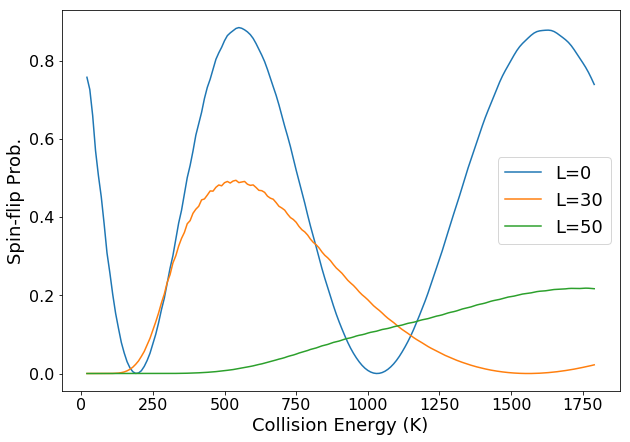

In [858]:
f=plt.figure(figsize=(10,7))
Tlist = np.array(Elist)*1.4
plt.plot(Elist,outlist0,label="L=0")
plt.plot(Elist,outlist30,label="L=30")
plt.plot(Elist,outlist50,label="L=50")
plt.xlabel("Collision Energy (K)")
plt.ylabel("Spin-flip Prob.")
plt.legend()
#f.savefig("AtomAtomVersusE.pdf",bbox_inches='tight')

Examine S-matrix versus partial wave.

In [886]:
outlist280 = []
Llist = range(30)
for ll in Llist:
    y,K,S = logderiv(400,0.005,22,280,ll)
    outlist280.append(abs(S[0,1])**2)

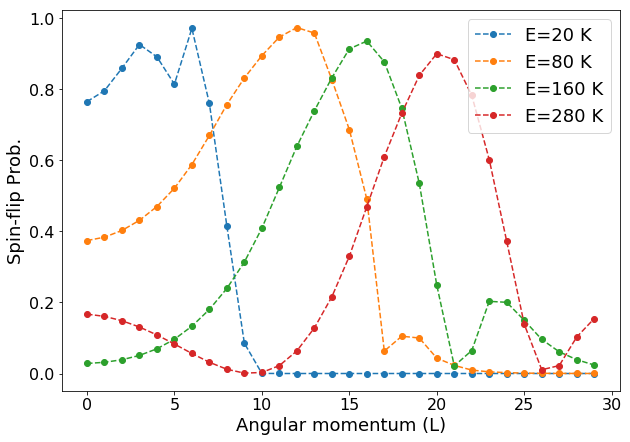

In [888]:
f=plt.figure(figsize=(10,7))
Tlist = np.array(Elist)*1.4
plt.plot(Llist,outlist20,'o--',label="E=20 K")
plt.plot(Llist,outlist80,'o--',label="E=80 K")
plt.plot(Llist,outlist160,'o--',label="E=160 K")
plt.plot(Llist,outlist280,'o--',label="E=280 K")
plt.xlabel("Angular momentum (L)")
plt.ylabel("Spin-flip Prob.")
plt.legend()
#f.savefig("AtomAtomVersusL.pdf",bbox_inches='tight')

In [859]:
m = 5193.0
ICS = []
nterms = []
Elist = range(5,100,1)
for EE in Elist:
    ll=0
    outlist = []
    sig = 1
    while (sig) > 0.001:
        y,K,S = logderiv(500,0.00001,22,EE,ll)
        sig = abs(S[0,1])**2
        outlist.append(sig)
        ll+=1
    totalsig = (np.pi**2)/(sqrt(2*m*EE))*np.sum((2*np.array(range(ll))+1)*outlist)
    ICS.append(totalsig)
    nterms.append(ll)

/Users/Ben/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in sqrt


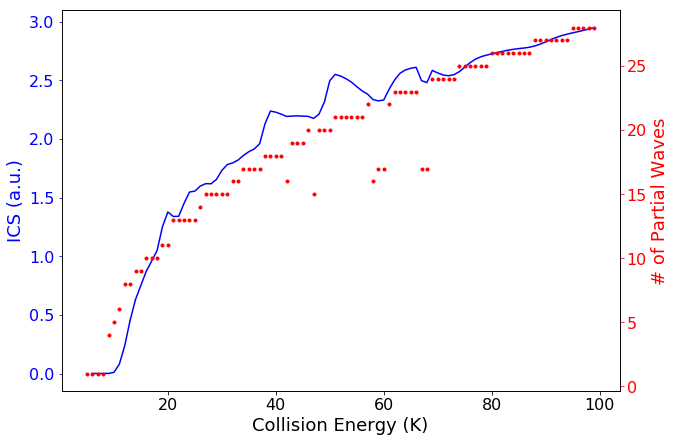

In [860]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(Elist,ICS,'b')
ax1.set_ylabel('ICS (a.u.)',color='b')
ax1.tick_params('y',colors='b')
ax2 = ax1.twinx()
ax2.plot(Elist, nterms, 'r.')
ax2.set_ylabel('# of Partial Waves', color='r')
ax2.tick_params('y', colors='r')
ax1.set_xlabel('Collision Energy (K)')
#fig.savefig("ICSandPartialWaves.pdf",bbox_inches='tight')